Notebook con entrenamiento del modelo XGBoost con el dataframe con medias ponderadas

Autor: Mateo Turati

Descripción: Obtengo los datos de train, validación y test. Creo dos modelo de XGBoostClassifier usando  dos métodos de ajuste de hiperparámetros y estudio sus resultados

Moficaciones:
Andrés: He cambiado el codigo para que los modelos usaen la GPU para entrenar *Mateo: Ya vi que se podía hacer pero tarda más

* [Carga de los datos](#carga-de-los-datos)
* [Modelo Baseline](#modelo-baseline)
* [Transformaciones](#transformaciones)
* [Selección de variables](#selección-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparámetros)
* [Conclusiones](#conclusiones)

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import mlflow

In [82]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

# Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


#### CARGA DE LOS DATOS

Cargamos el conjunto de train y test los cuales han sido seleccionados respetando el orden cronológico debido a que es una serie temporal.

In [83]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2011-01-22,Melvin Guillard,Evan Dunham,False,0.24,0.00,0.4772,0.3612,0.0000,0.4200,...,12.108597,0.000000,12,5,0.24,0.1160,-0.475248,-3.16,0.80,-185.76
1,2011-02-26,George Sotiropoulos,Dennis Siver,True,0.24,0.36,0.2548,0.2912,0.4812,0.1600,...,20.371815,17.247681,7,10,-0.12,-0.0364,0.081182,1.56,0.00,228.72
2,2011-03-19,Ricardo Almeida,Mike Pyle,True,0.00,0.24,0.5056,0.5132,0.4500,0.1368,...,12.872598,1.603038,10,5,-0.24,-0.0076,0.255163,-1.08,-0.24,238.92
3,2011-03-19,Mirko Filipovic,Brendan Schaub,True,0.24,1.00,0.3820,0.5688,0.0000,0.0000,...,0.159050,10.115785,8,4,-0.76,-0.1868,0.000000,0.88,0.00,143.08
4,2011-03-19,Dan Miller,Nate Marquardt,True,0.00,0.00,0.3032,0.3912,0.4600,0.2700,...,13.098965,2.734214,8,13,0.00,-0.0880,0.093856,-0.92,-0.40,188.52


In [84]:
ruta_test = os.path.join("..","..","..","data", "P2","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-02-04,Derrick Lewis,Serghei Spivac,True,0.40,0.00,0.5864,0.3636,0.1200,0.4500,...,186.452628,8.428689e+01,25,9,0.40,0.2228,-0.307248,-0.36,0.0,-136.44
1,2023-02-04,Dooho Choi,Kyle Nelson,True,0.36,0.00,0.4824,0.6552,0.0800,0.0000,...,0.000000,0.000000e+00,6,5,0.36,-0.1728,0.133333,0.00,0.0,-61.20
2,2023-02-04,Marcin Tybura,Blagoy Ivanov,False,0.00,0.00,0.4276,0.5056,0.2000,0.2792,...,141.263914,2.759667e-07,16,6,0.00,-0.0780,-0.188071,-0.40,0.0,-56.72
3,2023-02-11,Tyson Pedro,Modestas Bukauskas,True,0.60,0.00,0.6544,0.4112,0.0000,0.0000,...,27.219766,0.000000e+00,8,4,0.60,0.2432,0.000000,0.40,0.0,16.88
4,2023-02-11,Islam Makhachev,Alexander Volkanovski,False,0.36,0.24,0.6300,0.5844,0.7576,0.1200,...,324.423336,5.369947e+02,13,12,0.12,0.0456,0.130692,1.16,-0.8,5.28


In [69]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.561973
True     0.438027
Name: proportion, dtype: float64

In [70]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.550505
True     0.449495
Name: proportion, dtype: float64

Comprobamos que no haya diferencias en la distribución de la variable respuesta entre los conjuntos.

#### MODELO BASELINE

Creo un modelo simple el cual debería conseguir mejorar tras realizar los ajustes de hiperparámetros. Para este modelo usaré los hiperparámetros por defecto de XGBoost, sin tener en cuenta los ligeros desbalances de clase ni eliminando atributos no útiles.

In [85]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [86]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_test)
y_val_prob = base.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5538720538720538
F1-Score: 0.4668
AUC-ROC: 0.5414
Precisión: 0.5043
Sensibilidad: 0.4345
Log-loss: 0.9289262090613591


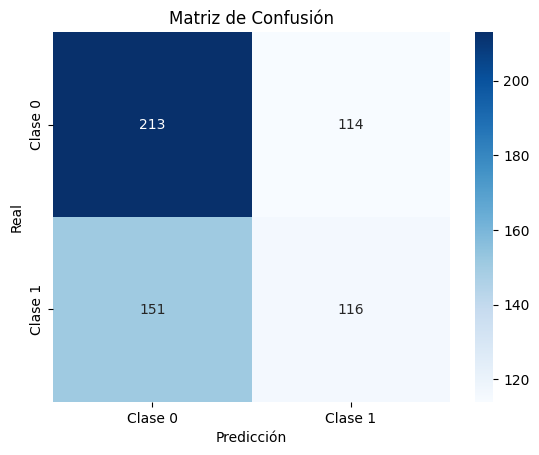

In [73]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

En nuestro caso eliminamos algunas variables que no aportaban información al modelo para reducir el coste computacional.

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

Como podemos ver en nuestro modelo baseline hay problemas notables respecto a las predicciones de la Clase-1, intentaremos conseguir un mejor modelo usando las técnicas de ajuste de hiperparámetros

In [74]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [1, 3],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

In [75]:
mlflow.set_experiment("Prueba con Puntos tipo elo XGBoost")

<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/220531053739985843', creation_time=1742411979960, experiment_id='220531053739985843', last_update_time=1742411979960, lifecycle_stage='active', name='Prueba con Puntos tipo elo XGBoost', tags={}>

In [76]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)


-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Mejores parámetros: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': np.float64(1.2829643888354187), 'subsample': 1.0}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.59      0.57      0.58       327
        True       0.49      0.52      0.51       267

    accuracy                           0.55       594
   macro avg       0.54      0.54      0.54       594
weighted avg       0.55      0.55      0.55       594



In [77]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5454545454545454
F1-Score: 0.5055
AUC-ROC: 0.5645
Precisión: 0.4946
Sensibilidad: 0.5169
Log-loss: 0.7075057011314262


In [78]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="con k=25 y victorias/derrotas fuera de las medias"):

    # Guardar modelo en MLflow
    mlflow.xgboost.log_model(best_grid, "modelo_xgboost")
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_val)

    print("Modelo guardado en MLflow")

c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/19 21:06:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/19 21:06:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo guardado en MLflow


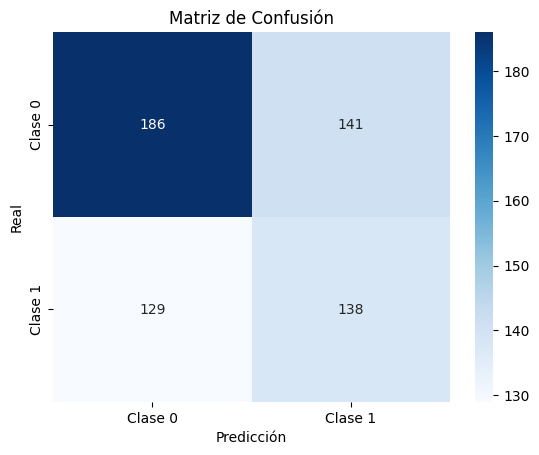

In [79]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [80]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                 Feature  Importance
62               Racha_A    0.019523
73             CTRL_DIFF    0.018502
21          STR_HEAD_B_x    0.018499
8                  REV_A    0.016649
68               KD_DIFF    0.016217
..                   ...         ...
32      STR_DISTANCE_A_x    0.010958
52        Derrotas_Sub_A    0.010635
0                   KD_A    0.010478
48        Victorias_KO_A    0.010333
56  Victorias_Decision_B    0.008985

[74 rows x 2 columns]


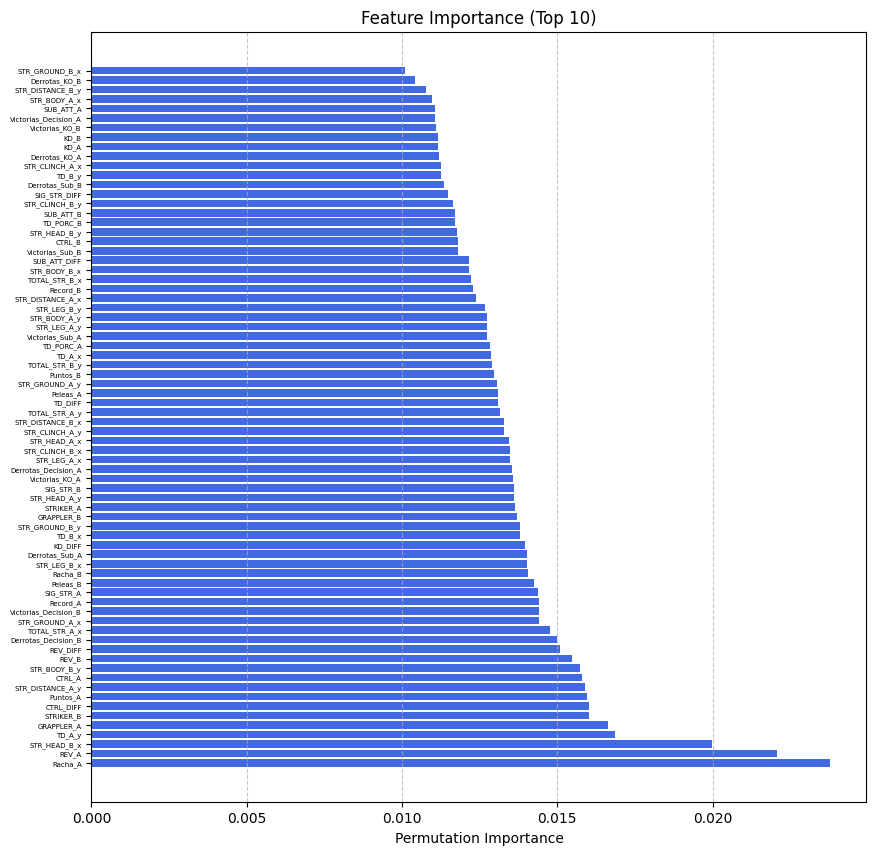

In [139]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [14]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 30, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))


    return random_search

In [15]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
resultados_random = train_xgboost_random(X_train,y_train,X_test,y_test)
best_random = resultados_random.best_estimator_
results_cv = resultados_random.cv_results_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'subsample': np.float64(0.8), 'scale_pos_weight': np.float64(1.2829643888354187), 'n_estimators': np.int64(200), 'min_child_weight': np.int64(7), 'max_depth': np.int64(6), 'learning_rate': np.float64(0.052222222222222225), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(0.9)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.58      0.58      0.58       327
        True       0.49      0.49      0.49       267

    accuracy                           0.54       594
   macro avg       0.53      0.53      0.53       594
weighted avg       0.54      0.54      0.54       594



In [16]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_test)
y_val_prob = best_random.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_test, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5387205387205387
F1-Score: 0.4888
AUC-ROC: 0.5671
Precisión: 0.4870
Sensibilidad: 0.4906
Log-loss: 0.7262313279498381
[[189 138]
 [136 131]]


In [18]:
df_cv_results = pd.DataFrame(results_cv)
df_cv_results = df_cv_results.sort_values(by="rank_test_score")
df_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
37,0.706908,0.237064,0.016174,0.000828,0.8,1.282964,200,7,6,0.052222,...,0.9,"{'subsample': 0.8, 'scale_pos_weight': 1.28296...",0.489766,0.536897,0.524019,0.566536,0.568400,0.537123,0.029182,1
44,0.834012,0.378356,0.016770,0.002695,0.9,1.282964,300,3,21,0.200000,...,0.7,"{'subsample': 0.9, 'scale_pos_weight': 1.28296...",0.526229,0.541268,0.537759,0.547233,0.530888,0.536676,0.007434,2
20,1.019479,0.449062,0.014795,0.000999,0.6,1.282964,200,1,15,0.200000,...,0.8,"{'subsample': 0.6, 'scale_pos_weight': 1.28296...",0.479687,0.529150,0.546444,0.579957,0.547199,0.536488,0.032813,3
21,0.823219,0.344278,0.015904,0.003171,1.0,1.282964,150,1,12,0.157778,...,0.5,"{'subsample': 1.0, 'scale_pos_weight': 1.28296...",0.521953,0.531448,0.521687,0.532995,0.568036,0.535224,0.017060,4
23,0.493990,0.108295,0.015680,0.002526,0.9,1.000000,300,5,3,0.094444,...,1.0,"{'subsample': 0.9, 'scale_pos_weight': 1, 'n_e...",0.480194,0.534096,0.560617,0.557642,0.542895,0.535089,0.029106,5


In [19]:
def plot_feature_importances(model, X_val, y_val, feature_names):
    # Calcular la importancia de permutación
    perm_importance = permutation_importance(model, X_val, y_val, scoring="f1_macro", n_repeats=10, random_state=42, n_jobs=-1)
    
    # Ordenar características por importancia
    sorted_idx = np.argsort(perm_importance.importances_mean)[-10:] # Tomar el top 10

    # Graficar las importancias
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx], 
             xerr=perm_importance.importances_std[sorted_idx], color="royalblue")
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance (Top 10)")
    plt.yticks(fontsize=10)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

In [20]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                 Feature  Importance
54         Derrotas_KO_A    0.017749
62               Racha_A    0.017286
12         TOTAL_STR_A_x    0.016715
17                TD_B_x    0.016233
64              Puntos_A    0.015841
..                   ...         ...
60              Record_A    0.011944
49        Victorias_KO_B    0.011855
51       Victorias_Sub_B    0.011739
46            GRAPPLER_A    0.011711
52  Victorias_Decision_A    0.011214

[74 rows x 2 columns]


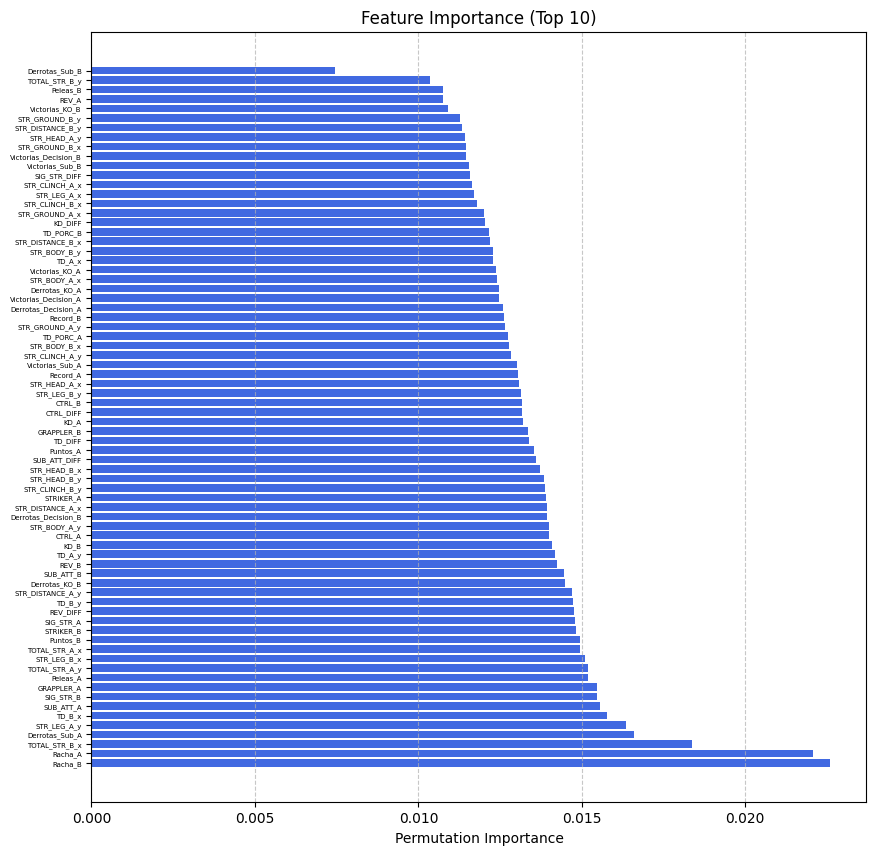

In [131]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

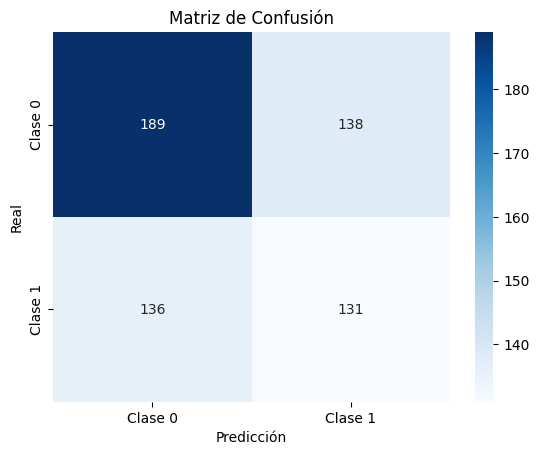

In [21]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

#### CONCLUSIONES

Tras comparar ambas estrategias, observamos que GridSearchCV tiende a encontrar combinaciones de hiperparámetros más óptimas para mejorar el F1-score, ya que evalúa exhaustivamente todas las posibles combinaciones. Sin embargo, esto conlleva un mayor coste computacional. Por otro lado, RandomizedSearchCV, aunque no explora todas las combinaciones, logra un resultado competitivo con un tiempo de ejecución significativamente menor. En este caso, si bien el modelo obtenido con RandomizedSearchCV muestra un F1-score algo inferior, ha destacado en otras métricas como el accuracy, lo que sugiere que puede ser una alternativa eficiente dependiendo de las restricciones computacionales y los objetivos del modelo.

Hemos conseguido mejorar el resultado del modelo baseline lo cual nos indica que los ajustes de hiperparámetros han sido correctos. 
No hemos conseguido obtener buenos resultados en temas de accuracy, consideramos que esto se debe a que al realizar las medias ponderadas muchos datos no son tan representativos y no tienen gran relación con el ganador de un futuro combate. A esta conclusión llegamos viendo que la importancia de las variables es bastante baja y muchas variables pierden mucha importancia respecto al modelo con datos reales de peleas.